# DLC and Loads Comparisons between AWC Cases

In [1]:
#!/usr/bin/env python3
import os,sys
import numpy as np 
#import ruamel.yaml as yaml
import yaml
import argparse
import pathlib
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
import fatpack


### Helper Functions

In [2]:
def approximate_period(AWC,RotSpeed,time,windSpeed,diam,st,dt,t1=120,time_interval=600):
    """
    t1 - transient time to ignore
    """
    omega_e = 2*np.pi * float(st) * float(windSpeed) / float(diam)

    t2 = t1 + time_interval #length of simulation 
    t2_history = []
    t2_temp = t2
    for i in range(25): # iterate 10 times to converge
        mask = (time <= t2_temp) & (time  >= t1)
        RotSpeed_Window = RotSpeed[mask]
        meanRPM       = np.mean(RotSpeed_Window)
        Omega = meanRPM*2*np.pi/60

        if 'Baseline' in AWC:
            return t2_temp

        elif 'Pulse' in AWC:
            period = (omega_e / (2*np.pi))**(-1)

        elif 'Helix' in AWC: 
            period = ( (Omega + omega_e) / (2*np.pi))**(-1)

        elif 'SideToSide' in AWC:
            period = (2*omega_e / (2*np.pi))**(-1)
        else:
            return t2_temp

        t2_history = np.append(t2_history, t2_temp)
        t2_temp = t1 + np.floor(time_interval/ period) * period 
        t2_temp = np.floor(t2_temp/dt)*dt #approximate end time as multiple of dt 

    return t2_temp
    

### Set parameters and load data

In [3]:
turbine = 'T0'
parentdir = '/ascldap/users/gyalla/GPFS/Advanced_Controls/AdvancedControlsWakes/Runs/MedWS_LowTI.Frontier/oneturb_4x2/'

dirs = ['Baseline',\
    'WM_Helix_A2_St_0p3',\
    'WM_Helix_A4_St_0p3',\
    'WM_Pulse_A2_St_0p3',\
    'WM_Pulse_A4_St_0p3',\
    'WM_SideToSide_A2_St_0p3',\
    'WM_SideToSide_A4_St_0p3',\
    'WS_m10',\
    'WS_m20',\
    'WS_p10',\
    'WS_p20']

#dirs = ['Baseline',]

# dirs = ['Baseline',\
#     'WM_Helix_A2_St_0p3',\
#     'WM_Helix_A4_St_0p3',\
#     'WM_Pulse_A2_St_0p3',\
#     'WM_Pulse_A4_St_0p3',\
#     'WM_SideToSide_A2_St_0p3',\
#     'WM_SideToSide_A4_St_0p3']


case_names = dirs

AWC_ST = 0.3
AWC_DIAM = 240.0         
windcases = [9,]
vars_and_labels = {'Time':('Time','s'),
            'RotSpeed':('Rotor Speed','rad / s'),
            'GenPwr':('Gen. Power','W'),
            'BldPitch1':('Blade Pitch','deg / s'),
            'RootMyb1':('Flapwise Moment','kN-m'), 
            'RootMxb1':('Edgewise Moment','kN-m'),
            'RotTorq':('Rotor Torque','kN-m'),
            'TwrBsMxt':('Tower base side-to-side moment','kN-m'),
            'TwrBsMyt':('Tower base Fore-aft Moment','kN-m'),
            'YawBrMyp':('Yaw Bearing Nodding Moment','kN-m'),
            'YawBrMzp':('Yaw Bearing Yawing Moment','kN-m'),
            'LSSTipMys':('LSS Nodding Moment','kN-m'),
            'LSSTipMzs':('LSS Yawing Moment','kN-m')}
vars = list(vars_and_labels.keys())
print(vars)

['Time', 'RotSpeed', 'GenPwr', 'BldPitch1', 'RootMyb1', 'RootMxb1', 'RotTorq', 'TwrBsMxt', 'TwrBsMyt', 'YawBrMyp', 'YawBrMzp', 'LSSTipMys', 'LSSTipMzs']


In [4]:
openfastData = {}
counter = 0
for caseiter, case in enumerate(case_names):
    openfastData[case] = {}
    for mps in windcases:
        dfs = [] 
        for variter , var in enumerate(vars):
            file = parentdir + dirs[caseiter] + '/postpro/OpenFAST/' + turbine + '_' + var + '.dat'
            print('Reading from: ', file)
            #df = pd.read_csv(file,sep='\s+',skiprows=(1,))
            df = pd.read_csv(file,sep=' ',skiprows=(1,))
            #print(df)
            #duplicates = df[df.duplicated(subset='Time', keep=False)]
            df.drop_duplicates(subset='Time', inplace=True)
            if variter == 0:
                dfs = df
            if variter > 0:
                dfs = pd.merge(dfs, df, on="Time")
        print(dfs)
        openfastData[case][str(mps)] = dfs
        #counter += 1
        print(openfastData[case][str(mps)].keys())

Reading from:  /ascldap/users/gyalla/GPFS/Advanced_Controls/AdvancedControlsWakes/Runs/MedWS_LowTI.Frontier/oneturb_4x2/Baseline/postpro/OpenFAST/T0_Time.dat
Reading from:  /ascldap/users/gyalla/GPFS/Advanced_Controls/AdvancedControlsWakes/Runs/MedWS_LowTI.Frontier/oneturb_4x2/Baseline/postpro/OpenFAST/T0_RotSpeed.dat
Reading from:  /ascldap/users/gyalla/GPFS/Advanced_Controls/AdvancedControlsWakes/Runs/MedWS_LowTI.Frontier/oneturb_4x2/Baseline/postpro/OpenFAST/T0_GenPwr.dat
Reading from:  /ascldap/users/gyalla/GPFS/Advanced_Controls/AdvancedControlsWakes/Runs/MedWS_LowTI.Frontier/oneturb_4x2/Baseline/postpro/OpenFAST/T0_BldPitch1.dat
Reading from:  /ascldap/users/gyalla/GPFS/Advanced_Controls/AdvancedControlsWakes/Runs/MedWS_LowTI.Frontier/oneturb_4x2/Baseline/postpro/OpenFAST/T0_RootMyb1.dat
Reading from:  /ascldap/users/gyalla/GPFS/Advanced_Controls/AdvancedControlsWakes/Runs/MedWS_LowTI.Frontier/oneturb_4x2/Baseline/postpro/OpenFAST/T0_RootMxb1.dat
Reading from:  /ascldap/users/gya

### Compute Means and DELs

In [5]:
#compute means and DEL 
caseMeans = {}
caseDELs = {}

caseMeansRel = {}
caseDELsRel = {}
nr_list = []
total_time_list = []
for caseiter, case in enumerate(case_names):
    caseMeans[case] = {}
    caseDELs[case] = {}
    caseMeansRel[case] = {}
    caseDELsRel[case] = {}
    #time average quantities 
    caseMeans[case]['ws'] = windcases
    caseDELs[case]['ws'] = windcases
    caseMeansRel[case]['ws'] = windcases
    caseDELsRel[case]['ws'] = windcases
    for cname in vars:
        caseMeans[case][cname] = []
        caseDELs[case][cname] = []
        caseMeansRel[case][cname] = []
        caseDELsRel[case][cname] = []
    nr_list.append([])
    total_time_list.append([])
    for mps in windcases:
        time  = openfastData[case][str(mps)]['Time']
        dt    = openfastData[case][str(mps)]['Time'][1] - openfastData[case][str(mps)]['Time'][0]
        tinit = 500
        RotSpeed= openfastData[case][str(mps)]['RotSpeed']
        tfinal = approximate_period(case,RotSpeed,time,mps,AWC_DIAM,AWC_ST,dt,t1=tinit,time_interval=1200-tinit)
        total_time = tfinal - tinit
        nmean = int(total_time/dt)
        nel = len(openfastData[case][str(mps)].Time) #number of timesteps
        print(case,nel,dt,total_time)
        #nr = np.array(range(nel-nmean,nel))             
        nel_init = int(tinit/dt)
        nr = np.array(range(nel_init,nel_init+nmean))             
        total_time_list[caseiter].append(total_time)
        nr_list[caseiter].append(nr)
        print(case," ",tfinal," ",nr)


    wc_counter = 0
    for mps in windcases:
        nr = nr_list[caseiter][wc_counter]
        total_time = total_time_list[caseiter][wc_counter]
        wc_counter +=1 
        for cname in vars:
            cdata = openfastData[case][str(mps)][cname]
            #append for each wind speed
            caseMeans[case][cname].append(np.mean(cdata[nr]))

            baseline_data = openfastData['Baseline'][str(mps)][cname]
            #caseMeansRel[case][cname].append( np.mean(((cdata[nr]-baseline_data[nr])/baseline_data[nr])))
            caseMeansRel[case][cname].append(np.mean(baseline_data[nr]))
            try:
                binNum = 100
                m=10
                t=total_time
                ranges = fatpack.find_rainflow_ranges(cdata[nr])
                Nrf, Srf = fatpack.find_range_count(ranges,binNum)
                DELs = Srf**m * Nrf / t
                DEL = DELs.sum() ** (1/m)

                baseline_data = openfastData['Baseline'][str(mps)][cname]
                binNum = 100
                m=10
                t=total_time
                ranges = fatpack.find_rainflow_ranges(baseline_data[nr])
                Nrf, Srf = fatpack.find_range_count(ranges,binNum)
                DELs = Srf**m * Nrf / t
                baseline_DEL = DELs.sum() ** (1/m)
            except:
                DEL = 0.0
                baseline_DEL = 1.0
            caseDELs[case][cname].append(np.mean(DEL))
            caseDELsRel[case][cname].append((DEL-baseline_DEL)/baseline_DEL)


Baseline 60001 0.02 700
Baseline   1200   [25000 25001 25002 ... 59997 59998 59999]


WM_Helix_A2_St_0p3 60001 0.02 699.6200000000001
WM_Helix_A2_St_0p3   1199.6200000000001   [25000 25001 25002 ... 59978 59979 59980]
WM_Helix_A4_St_0p3 60001 0.02 694.02
WM_Helix_A4_St_0p3   1194.02   [25000 25001 25002 ... 59698 59699 59700]
WM_Pulse_A2_St_0p3 60001 0.02 622.22
WM_Pulse_A2_St_0p3   1122.22   [25000 25001 25002 ... 56108 56109 56110]
WM_Pulse_A4_St_0p3 60001 0.02 622.22
WM_Pulse_A4_St_0p3   1122.22   [25000 25001 25002 ... 56108 56109 56110]
WM_SideToSide_A2_St_0p3 60001 0.02 666.6600000000001
WM_SideToSide_A2_St_0p3   1166.66   [25000 25001 25002 ... 58330 58331 58332]
WM_SideToSide_A4_St_0p3 60001 0.02 666.6600000000001
WM_SideToSide_A4_St_0p3   1166.66   [25000 25001 25002 ... 58330 58331 58332]
WS_m10 60001 0.02 700
WS_m10   1200   [25000 25001 25002 ... 59997 59998 59999]
WS_m20 60001 0.02 700
WS_m20   1200   [25000 25001 25002 ... 59997 59998 59999]
WS_p10 60001 0.02 700
WS_p10   1200   [25000 25001 25002 ... 59997 59998 59999]
WS_p20 60001 0.02 700
WS_p20   1200 

Baseline GenPwr [9136.665276150747]
WM_Helix_A2_St_0p3 GenPwr [9063.598484848484]
WM_Helix_A4_St_0p3 GenPwr [8923.907608069165]
WM_Pulse_A2_St_0p3 GenPwr [9107.88299582128]
WM_Pulse_A4_St_0p3 GenPwr [8942.125715204114]
WM_SideToSide_A2_St_0p3 GenPwr [9112.783661346453]
WM_SideToSide_A4_St_0p3 GenPwr [9045.16543158021]
WS_m10 GenPwr [8851.974084973855]
WS_m20 GenPwr [8008.458241664048]
WS_p10 GenPwr [8802.025315009001]
WS_p20 GenPwr [7901.468127660791]
Baseline RootMyb1 [48911.10371428572]
WM_Helix_A2_St_0p3 RootMyb1 [48716.6135902347]
WM_Helix_A4_St_0p3 RootMyb1 [48366.80355032996]
WM_Pulse_A2_St_0p3 RootMyb1 [49450.84825302948]
WM_Pulse_A4_St_0p3 RootMyb1 [50700.80871717399]
WM_SideToSide_A2_St_0p3 RootMyb1 [48811.19251192512]
WM_SideToSide_A4_St_0p3 RootMyb1 [48646.934269342695]
WS_m10 RootMyb1 [48078.93914285714]
WS_m20 RootMyb1 [45288.36971428571]
WS_p10 RootMyb1 [47585.48514285714]
WS_p20 RootMyb1 [44329.77085714286]


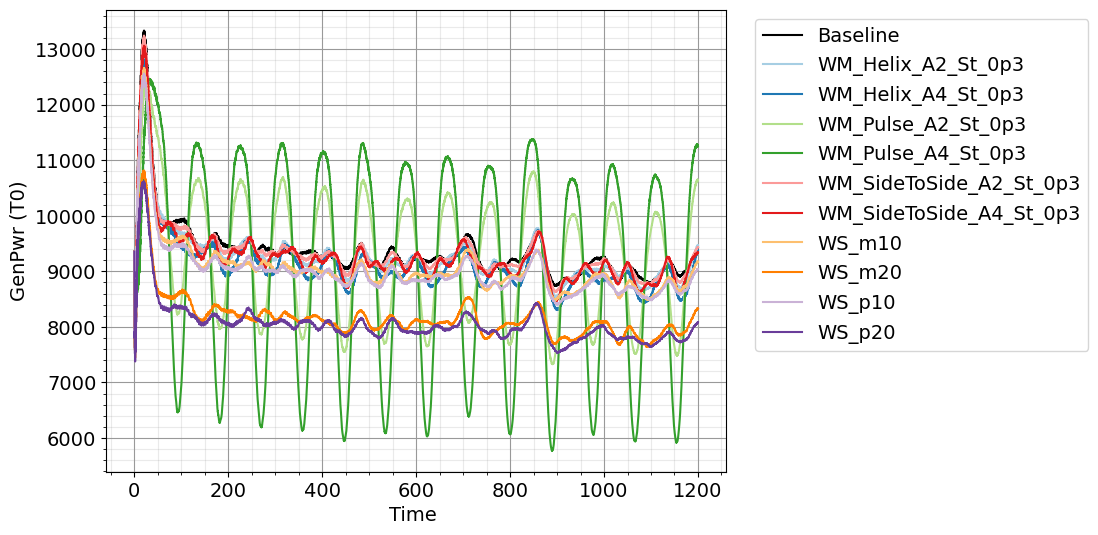

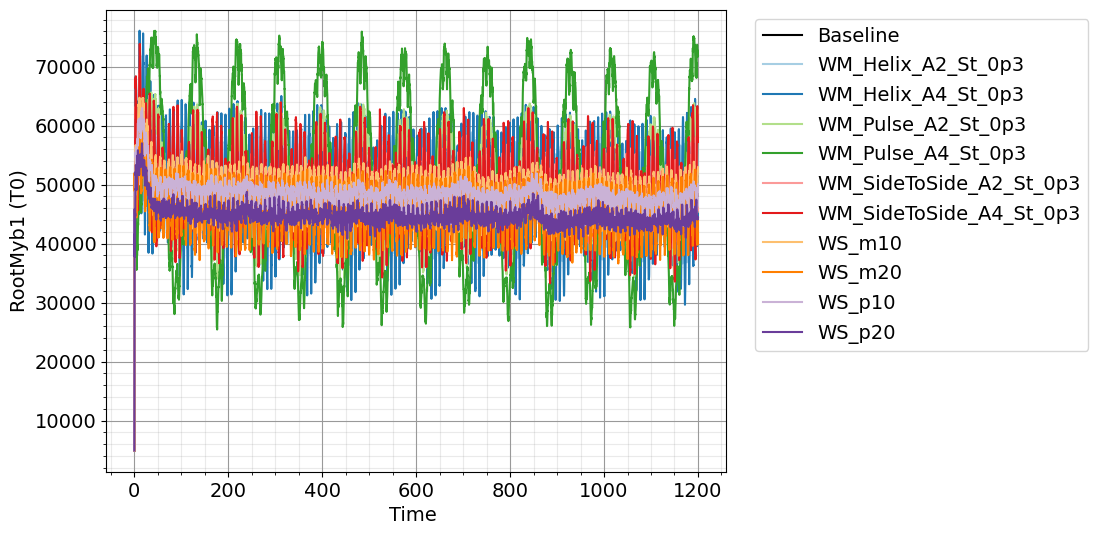

In [6]:
#plot mean data
#colors = ['k','tab:blue','tab:purple','tab:red']
colors = ['k','tab:blue','tab:red','tab:purple','tab:green']
colors = ['k','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
timeseries_vars = ['GenPwr','RootMyb1']
for tvar in timeseries_vars:
    fig, ax1 = plt.subplots(1,1,figsize=(8,6),sharex=False,sharey=True)
    counter = 0
    for caseiter, case in enumerate(case_names):
        #if "WS" not in case:
        if 'Baseline' in case:
            marker = '*'
        else:
            marker = '.'
        ax1.plot(openfastData[case][str(9)]['Time'],openfastData[case][str(9)][tvar],label=case,c=colors[counter])
        print(case,tvar,caseMeans[case][tvar])
        counter += 1

    fsize = 14
    #ax1[ax_counter].set_xlabel("DEL " + quantity,fontsize=fsize) 
    ax1.set_ylabel(tvar + " (T0)",fontsize=fsize)
    ax1.set_xlabel("Time ",fontsize=fsize)
    ax1.grid(visible=True, which='major', color='#999999', linestyle='-')
    ax1.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax1.minorticks_on()
    ax1.tick_params(axis='x',labelsize=fsize)
    ax1.tick_params(axis='y',labelsize=fsize)
    #ax1.ticklabel_format(style='sci',axis='x',scilimits=(0,0))

    ax1.legend(loc='upper right',bbox_to_anchor=(1.6,1),fontsize=fsize)

    counter = 0
    for caseiter, case in enumerate(case_names):
        #if "WS" not in case:
        if 'Baseline' in case:
            marker = '*'
        else:
            marker = '.'
        #ax1.scatter(total_time_list[caseiter][0]+tinit-(1200-tinit),12000,marker='D',c=colors[counter])
        #ax1.axvline(x=total_time_list[caseiter][0]+tinit, linestyle='dashed', color=colors[counter])
        counter += 1
    #ax1.axvline(x=tinit, linestyle='dashed', color='k')

In [7]:

### Rotor Averaged Velocities at 6D computed from ANDES

### Average over last 1000s
# rotorAvgVel = {'Baseline':6.639014135157093,\
#     'WM_Helix_A2_St_0p3':6.800847449238973,\
#     'WM_Helix_A4_St_0p3':6.972252155100067,\
#     'WM_Pulse_A2_St_0p3':6.79234066576847,\
#     'WM_Pulse_A4_St_0p3':7.113381184643743,\
#     'WM_SideToSide_A2_St_0p3':6.745681428342344,\
#     'WM_SideToSide_A4_St_0p3':6.874342331434563,\
#     'WS_m10':6.6273389806895295,\
#     'WS_p10':7.026769105728333,\
#     'WS_m20':6.866224786557339,\
#     'WS_p20':7.684634058247025}

### Averaged over the last 700s
rotorAvgVel7D = {'Baseline': 6.903564760736087,\
    'WM_Helix_A2_St_0p3': 7.065716829523863,\
    'WM_Helix_A4_St_0p3': 7.195935604670542,\
    'WM_Pulse_A2_St_0p3': 6.974606496960726,\
    'WM_Pulse_A4_St_0p3': 7.308159590020047,\
    'WM_SideToSide_A2_St_0p3': 7.022029943474004,\
    'WM_SideToSide_A4_St_0p3': 7.117812695286668,\
    'WS_m10': 6.8717176267542115,\
    'WS_p10': 7.2991833076665,\
    'WS_m20': 7.060863272355438,\
    'WS_p20': 7.934894031145309}

rotorAvgVel6D = {'Baseline': 6.517205610430913,\
    'WM_Helix_A2_St_0p3': 6.683983268680854,\
    'WM_Helix_A4_St_0p3': 6.851021115120054,\
    'WM_Pulse_A2_St_0p3': 6.694800720214245,\
    'WM_Pulse_A4_St_0p3': 7.055870869675111,\
    'WM_SideToSide_A2_St_0p3': 6.630486456000515,\
    'WM_SideToSide_A4_St_0p3': 6.776168441284765,\
    'WS_m10': 6.523259304246641,\
    'WS_p10': 6.913881680439711,\
    'WS_m20': 6.795311716894599,\
    'WS_p20': 7.602965084683708}

rotorAvgVel5D = {'Baseline': 6.05438240478382,\
    'WM_Helix_A2_St_0p3': 6.205003851018279,\
    'WM_Helix_A4_St_0p3': 6.392806400988304,\
    'WM_Pulse_A2_St_0p3': 6.322653267641049,\
    'WM_Pulse_A4_St_0p3': 6.6623392665093375,\
    'WM_SideToSide_A2_St_0p3': 6.124314398727591,\
    'WM_SideToSide_A4_St_0p3': 6.295826718769149,\
    'WS_m10': 6.110278833395582,\
    'WS_p10': 6.442575099217542,\
    'WS_m20': 6.478581200797137,\
    'WS_p20': 7.170319054746716}

rotorAvgVel4D = {'Baseline': 5.549343515839472,\
    'WM_Helix_A2_St_0p3': 5.7068501893620525,\
    'WM_Helix_A4_St_0p3': 5.917067588833592,\
    'WM_Pulse_A2_St_0p3': 5.891807168403848,\
    'WM_Pulse_A4_St_0p3': 6.263633621541957,\
    'WM_SideToSide_A2_St_0p3': 5.606249532659991,\
    'WM_SideToSide_A4_St_0p3': 5.79260213362355,\
    'WS_m10': 5.646994413928223,\
    'WS_p10': 5.907828876220843,\
    'WS_m20': 6.116349125747516,\
    'WS_p20': 6.6640112170209225}


Cp = 0.45 # Cp of the downwind machine
rmax = 240.0/2
Area = np.pi*rmax**2
rho = 1.2456
for caseiter, case in enumerate(case_names):
    for mps in windcases:
        caseMeans[case]['GenPwr4D'] = Cp*0.5*rho*float(rotorAvgVel4D[case])**3*Area/1000
        caseMeans[case]['GenPwr5D'] = Cp*0.5*rho*float(rotorAvgVel5D[case])**3*Area/1000
        caseMeans[case]['GenPwr6D'] = Cp*0.5*rho*float(rotorAvgVel6D[case])**3*Area/1000
        caseMeans[case]['GenPwr7D'] = Cp*0.5*rho*float(rotorAvgVel7D[case])**3*Area/1000


### Power T0 vs DEL T0

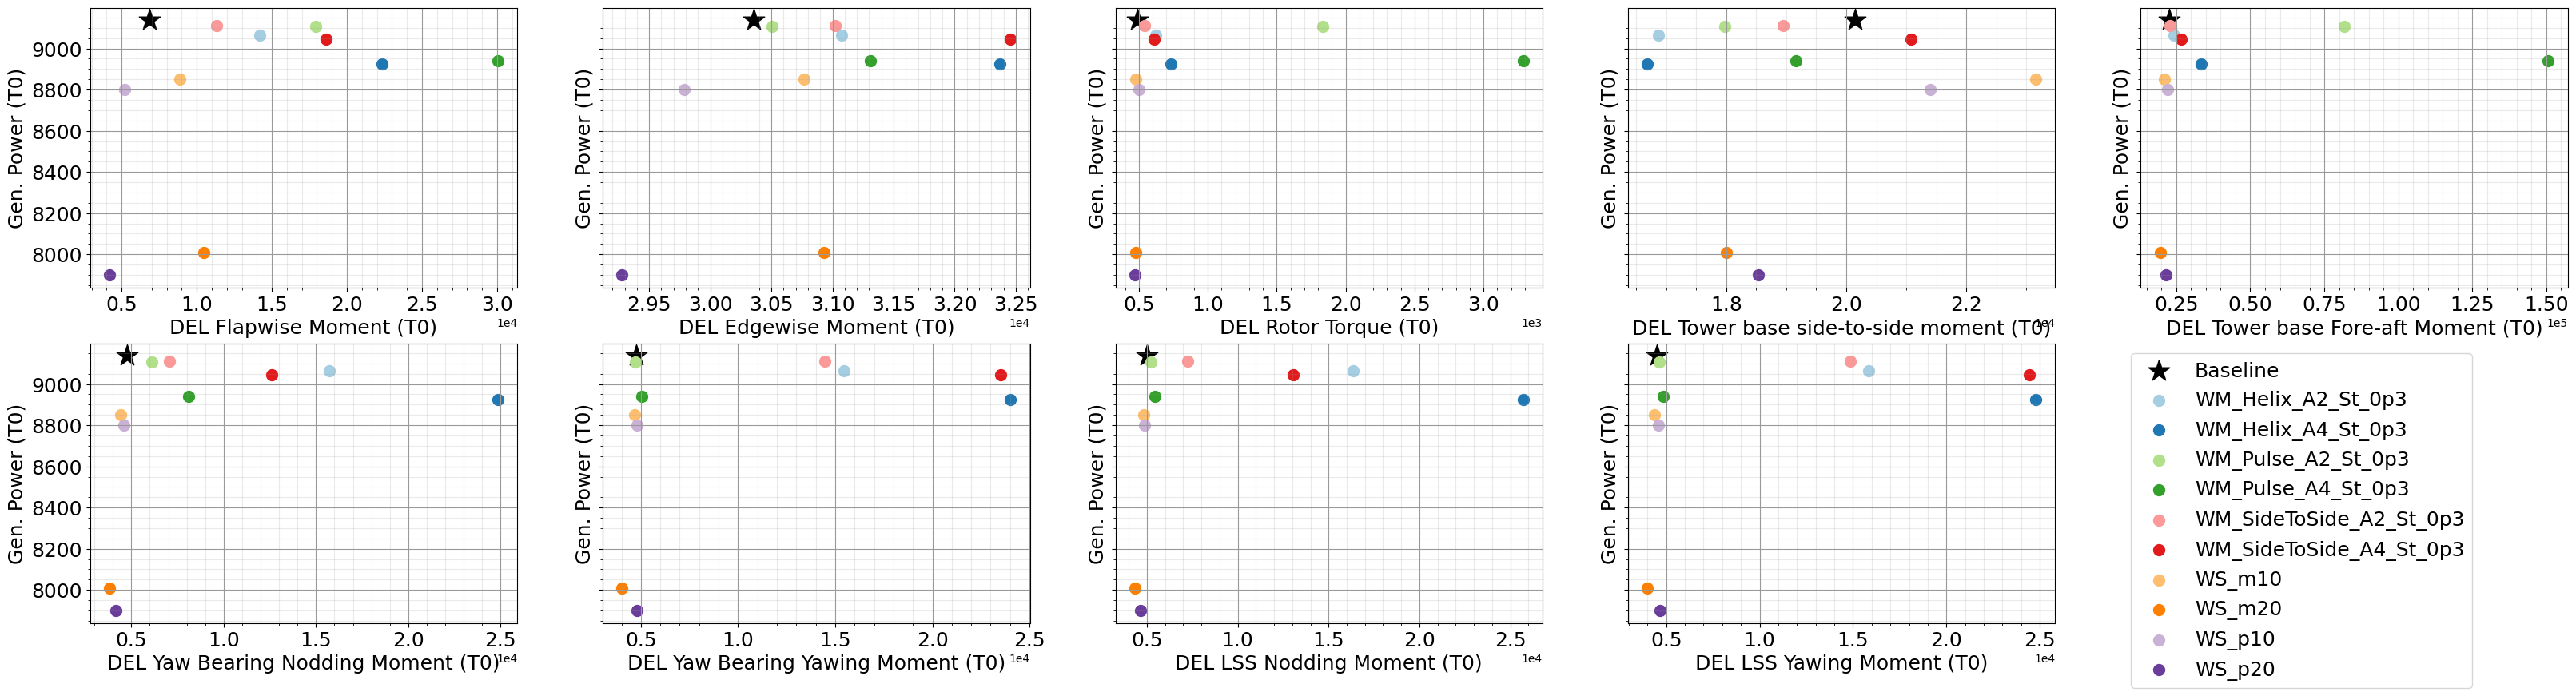

In [8]:
#plot mean data
#colors = ['k','tab:blue','tab:purple','tab:red']
colors = ['k','tab:blue','tab:red','tab:purple','tab:green']
colors = ['k','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
fig, ax1 = plt.subplots(2,5,figsize=(40,10),sharex=False,sharey=True)
ax1=ax1.flatten()
ax_counter = 0

for quantity in vars[4:]:
    counter = 0 
    for case in case_names:
        #if "WS" not in case:
        if 'Baseline' in case:
            marker = '*'
        else:
            marker = '.'
        ax1[ax_counter].scatter(caseDELs[case][quantity],caseMeans[case]['GenPwr'],label=case,c=colors[counter],marker=marker,s=400)
        counter += 1

    fsize = 18
    #ax1[ax_counter].set_xlabel("DEL " + quantity,fontsize=fsize) 
    ax1[ax_counter].set_ylabel("Gen. Power (T0)",fontsize=fsize)
    ax1[ax_counter].set_xlabel("DEL " + vars_and_labels[quantity][0] + " (T0)",fontsize=fsize)
    ax1[ax_counter].grid(visible=True, which='major', color='#999999', linestyle='-')
    ax1[ax_counter].grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax1[ax_counter].minorticks_on()
    ax1[ax_counter].tick_params(axis='x',labelsize=fsize)
    ax1[ax_counter].tick_params(axis='y',labelsize=fsize)
    ax1[ax_counter].ticklabel_format(style='sci',axis='x',scilimits=(0,0))

    #fig.legend(loc='upper right', bbox_to_anchor=(1, 1))
    #fig.tight_layout()
    ax_counter += 1

ax1[-1].axis('off')
ax1[-2].legend(loc='upper right',bbox_to_anchor=(2,1),fontsize=fsize)

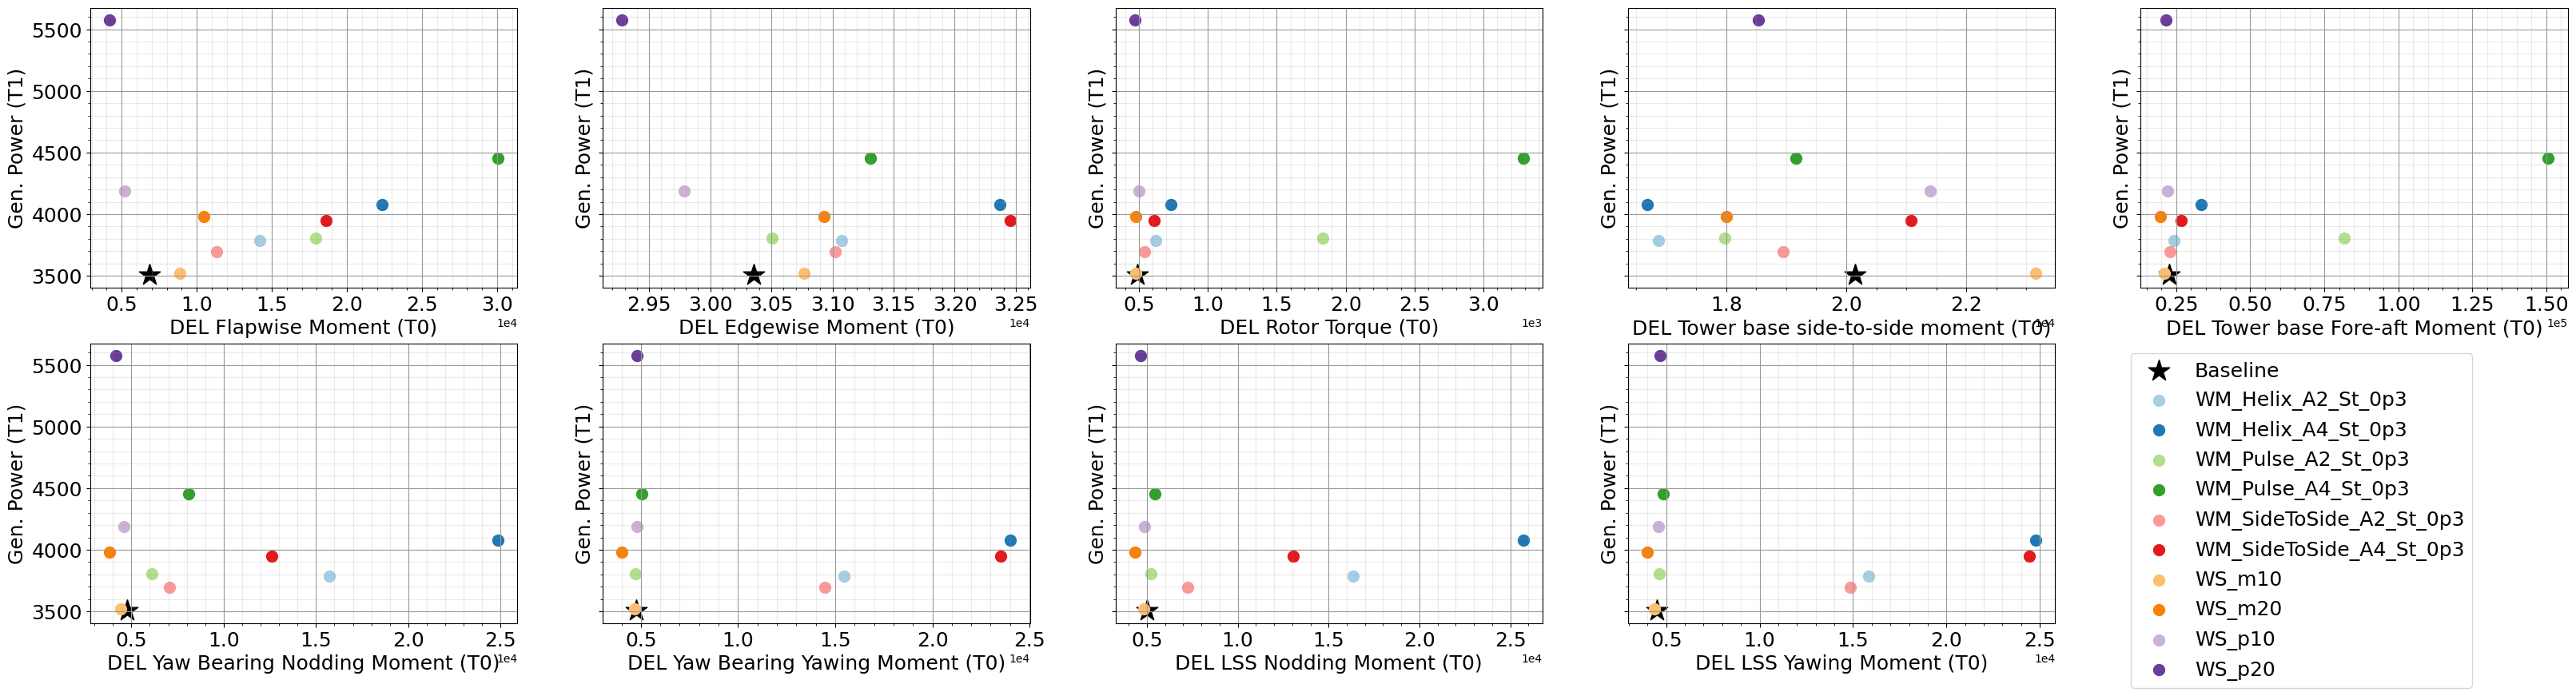

In [9]:
#plot mean data
#colors = ['k','tab:blue','tab:purple','tab:red']
colors = ['k','tab:blue','tab:red','tab:purple','tab:green']
colors = ['k','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
fig, ax1 = plt.subplots(2,5,figsize=(40,10),sharex=False,sharey=True)
ax1=ax1.flatten()
ax_counter = 0

for quantity in vars[4:]:
    counter = 0 
    for case in case_names:
        #if "WS" not in case:
        if 'Baseline' in case:
            marker = '*'
        else:
            marker = '.'
        GenPwrT1 = float(caseMeans[case]['GenPwr6D'])
        GenPwrT0 = float(caseMeans[case]['GenPwr'][0])
        GenPwrT0pT1 = GenPwrT0 + GenPwrT1
        ax1[ax_counter].scatter(caseDELs[case][quantity],GenPwrT1,label=case,c=colors[counter],marker=marker,s=400)
        counter += 1

    fsize = 18
    #ax1[ax_counter].set_xlabel("DEL " + quantity,fontsize=fsize) 
    ax1[ax_counter].set_ylabel("Gen. Power (T1)",fontsize=fsize)
    ax1[ax_counter].set_xlabel("DEL " + vars_and_labels[quantity][0] + " (T0)",fontsize=fsize)
    ax1[ax_counter].grid(visible=True, which='major', color='#999999', linestyle='-')
    ax1[ax_counter].grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax1[ax_counter].minorticks_on()
    ax1[ax_counter].tick_params(axis='x',labelsize=fsize)
    ax1[ax_counter].tick_params(axis='y',labelsize=fsize)
    ax1[ax_counter].ticklabel_format(style='sci',axis='x',scilimits=(0,0))

    #fig.legend(loc='upper right', bbox_to_anchor=(1, 1))
    #fig.tight_layout()
    ax_counter += 1

ax1[-1].axis('off')
ax1[-2].legend(loc='upper right',bbox_to_anchor=(2,1),fontsize=fsize)

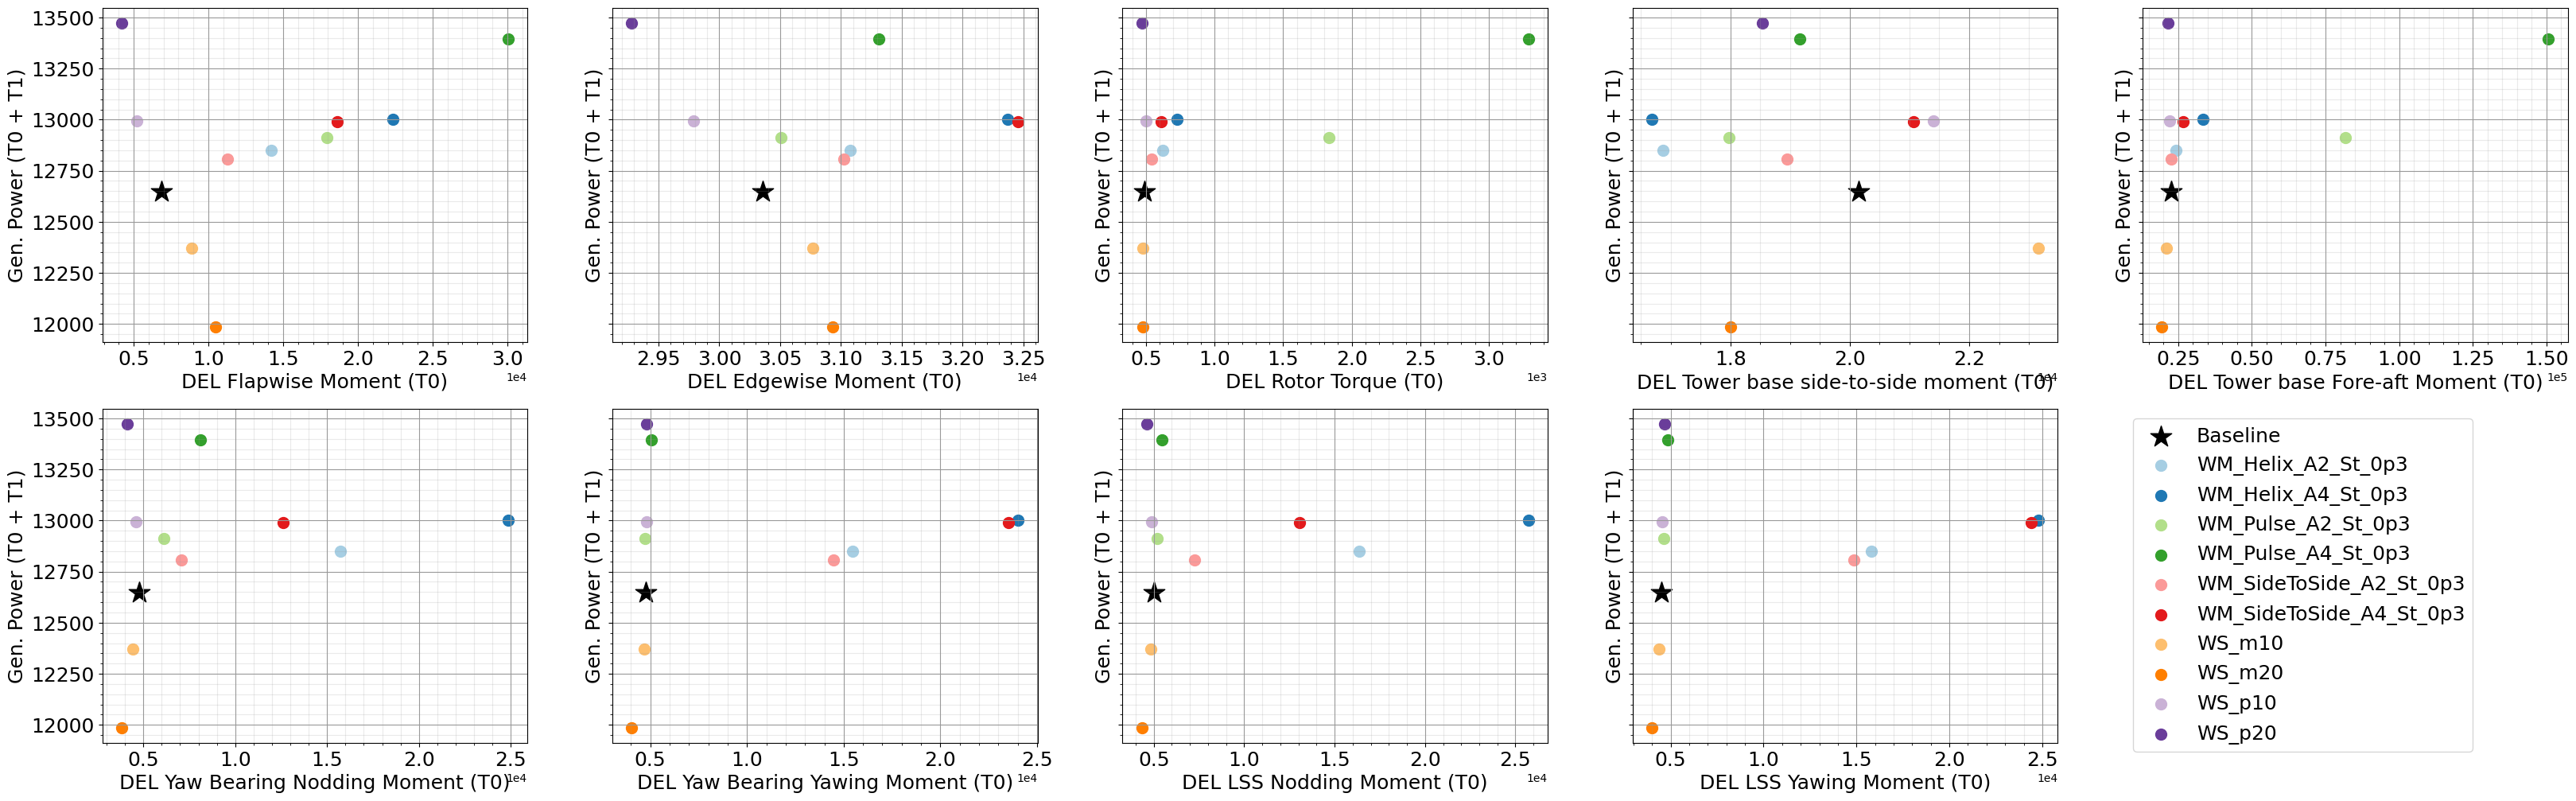

In [10]:
#plot mean data
#colors = ['k','tab:blue','tab:purple','tab:red']
colors = ['k','tab:blue','tab:red','tab:purple','tab:green']
colors = ['k','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
fig, ax1 = plt.subplots(2,5,figsize=(40,12),sharex=False,sharey=True)
ax1=ax1.flatten()
ax_counter = 0

for quantity in vars[4:]:
    counter = 0 
    for case in case_names:
        #if "WS" not in case:
        if 'Baseline' in case:
            marker = '*'
        else:
            marker = '.'
        GenPwrT1 = float(caseMeans[case]['GenPwr6D'])
        GenPwrT0 = float(caseMeans[case]['GenPwr'][0])
        GenPwrT0pT1 = GenPwrT0 + GenPwrT1
        ax1[ax_counter].scatter(caseDELs[case][quantity],GenPwrT0pT1,label=case,c=colors[counter],marker=marker,s=400)
        counter += 1

    fsize = 18
    #ax1[ax_counter].set_xlabel("DEL " + quantity,fontsize=fsize) 
    ax1[ax_counter].set_ylabel("Gen. Power (T0 + T1)",fontsize=fsize)
    ax1[ax_counter].set_xlabel("DEL " + vars_and_labels[quantity][0] + " (T0)",fontsize=fsize)
    ax1[ax_counter].grid(visible=True, which='major', color='#999999', linestyle='-')
    ax1[ax_counter].grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax1[ax_counter].minorticks_on()
    ax1[ax_counter].tick_params(axis='x',labelsize=fsize)
    ax1[ax_counter].tick_params(axis='y',labelsize=fsize)
    ax1[ax_counter].ticklabel_format(style='sci',axis='x',scilimits=(0,0))

    #fig.legend(loc='upper right', bbox_to_anchor=(1, 1))
    #fig.tight_layout()
    ax_counter += 1

ax1[-1].axis('off')
ax1[-2].legend(loc='upper right',bbox_to_anchor=(2,1),fontsize=fsize)

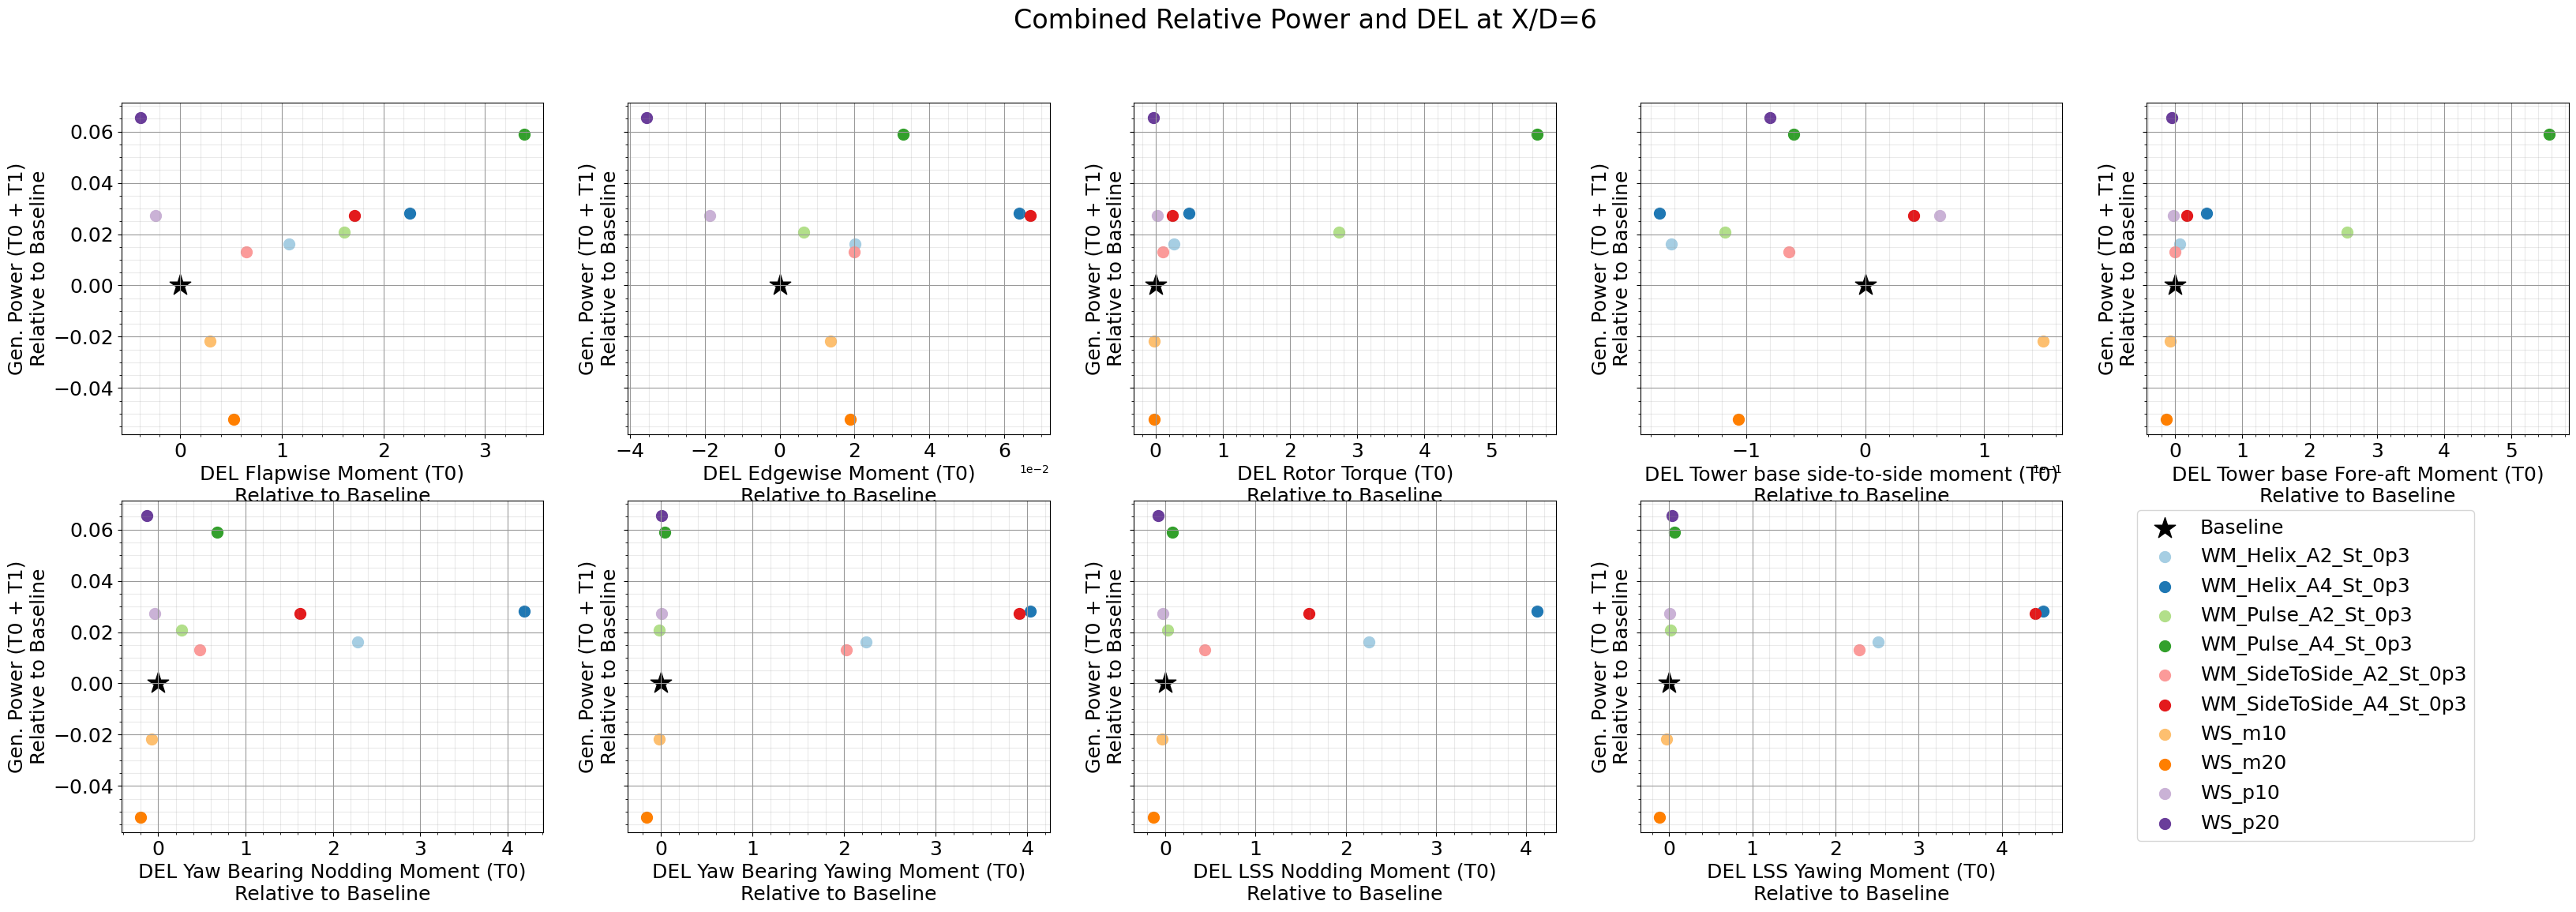

In [12]:
#plot mean data
#colors = ['k','tab:blue','tab:purple','tab:red']
colors = ['k','tab:blue','tab:red','tab:purple','tab:green']
colors = ['k','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
fig, ax1 = plt.subplots(2,5,figsize=(40,12),sharex=False,sharey=True)
ax1=ax1.flatten()
ax_counter = 0

for quantity in vars[4:]:
    counter = 0 
    for case in case_names:
        #if "WS" not in case:
        if 'Baseline' in case:
            marker = '*'
        else:
            marker = '.'
        pwrT1b = float(caseMeans['Baseline']['GenPwr6D'])
        pwrT1  = float((caseMeans[case]['GenPwr6D']))
        fig.suptitle("Combined Relative Power and DEL at X/D=6",fontsize=24)
        pwrT0  = float(caseMeans[case]['GenPwr'][0])
        pwrT0b = float(caseMeansRel[case]['GenPwr'][0])
        GenPwrT0pT1 = ((pwrT0 + pwrT1) - (pwrT0b + pwrT1b))/(pwrT0b + pwrT1b)
        ax1[ax_counter].scatter(caseDELsRel[case][quantity],GenPwrT0pT1,label=case,c=colors[counter],marker=marker,s=400)
        counter += 1

    fsize = 18
    #ax1[ax_counter].set_xlabel("DEL " + quantity,fontsize=fsize) 
    ax1[ax_counter].set_ylabel("Gen. Power (T0 + T1)\nRelative to Baseline",fontsize=fsize)
    ax1[ax_counter].set_xlabel("DEL " + vars_and_labels[quantity][0] + " (T0)\nRelative to Baseline",fontsize=fsize)
    ax1[ax_counter].grid(visible=True, which='major', color='#999999', linestyle='-')
    ax1[ax_counter].grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax1[ax_counter].minorticks_on()
    ax1[ax_counter].tick_params(axis='x',labelsize=fsize)
    ax1[ax_counter].tick_params(axis='y',labelsize=fsize)
    ax1[ax_counter].ticklabel_format(style='sci',axis='x',scilimits=(0,0))

    #fig.legend(loc='upper right', bbox_to_anchor=(1, 1))
    #fig.tight_layout()
    ax_counter += 1

ax1[-1].axis('off')
ax1[-2].legend(loc='upper right',bbox_to_anchor=(2,1),fontsize=fsize)